In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import lightgbm as lgb

from sklearn.metrics import mean_squared_error, mean_absolute_error, f1_score, make_scorer
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold

# from sklearn.feature_selection import SelectKBest, f_regression

In [2]:
np.random.seed(7)

# metrics

In [3]:
def mae(y_true, y_pred) :
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    
    y_true = y_true.reshape(1, -1)[0]
    y_pred = y_pred.reshape(1, -1)[0]
    over_threshold = y_true >= 0.1
    
    return np.mean(np.abs(y_true[over_threshold] - y_pred[over_threshold]))

def fscore(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    
    y_true = y_true.reshape(1, -1)[0]
    y_pred = y_pred.reshape(1, -1)[0]
    remove_NAs = y_true >= 0
    
    y_true = np.where(y_true[remove_NAs] >= 0.1, 1, 0)
    y_pred = np.where(y_pred[remove_NAs] >= 0.1, 1, 0)
    
    return (f1_score(y_true, y_pred))

def maeOverFscore(y_true, y_pred):
    return mae(y_true, y_pred) / (fscore(y_true, y_pred) + 1e-07)

def score(y_val, pred):
    f_value =  fscore(y_val, pred)
    mae_value = maeOverFscore(y_val, pred)
    print(f"fscore        : {f_value}")
    print(f"maeOverFscore : {mae_value}")
    
    return (f_value, mae_value)

fscore_sklearn = make_scorer(fscore)
maeOverFscore_sklearn = make_scorer(maeOverFscore)

# data load

In [4]:
base = os.getcwd()
data_path = os.path.join(base, 'data')
submit_path = os.path.join(base, 'submit')
model_path = os.path.join(base, 'model')

def load_data(name):
    return np.load(os.path.join(data_path, f"{name}.npy"))

def reshape(data):
    return data.reshape(data.shape[0] * 40 * 40, data.shape[-1])

In [5]:
data = reshape(load_data('dl_train'))

# Feature Selection

## select K
![img](feacture_selection.PNG)

### selectK 7
- [False, False,  True,  True,  True,  True,  True,  True, False, False, False, False, False, True]

### selectK 8
- [False, False,  True,  True,  True,  True,  True,  True, False, False, False, True, False, True]

In [6]:
selectK_7 = [2, 3, 4, 5, 6, 7, 13]
selectK_8 = [2, 3, 4, 5, 6, 7, 11, 13]

# seperate dataset

In [7]:
X = data[:, :-1]
Y = data[:,  -1].reshape(data.shape[0], 1)
data = range(data.shape[0])
print(X.shape, Y.shape)

(121561600, 14) (121561600, 1)


# Kfold

In [ ]:
kfold = KFold(n_splits=4, random_state=7, shuffle=False)
scores = list()

for i, (train_idx, val_idx) in enumerate(kfold.split(data)):
    clf = lgb.LGBMRegressor(boosting_type='dart', num_leaves=31, max_depth=- 1, learning_rate=0.01, \
                             n_estimators=600, subsample_for_bin=200000, objective=None, class_weight=None, \
                             min_split_gain=0.0, min_child_weight=0.001, min_child_samples=20, subsample=1.0, \
                             subsample_freq=0, colsample_bytree=1.0, reg_alpha=0.0, reg_lambda=0.0, random_state=None, \
                             n_jobs=- 1, silent=True, importance_type='split')
    

    clf.fit(X[train_idx, :], Y[train_idx, 0], eval_set=[(X[val_idx, :], Y[val_idx, 0])], \
            early_stopping_rounds=100, \
            verbose=True)
    
#     clf.save_model(os.path.join(model_path, f'lgb_dart_{i}.txt'), \
#                     num_iteration=clf.best_iteration)
    
    scores.append(score(clf.predict(X[val_idx, :]), Y[val_idx, :]))

/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


[1]	valid_0's l2: 3.62028


/home/ubuntu/anaconda3/lib/python3.7/site-packages/lightgbm/callback.py:188: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[2]	valid_0's l2: 3.60018
[3]	valid_0's l2: 3.58033
[4]	valid_0's l2: 3.56099
[5]	valid_0's l2: 3.542
[6]	valid_0's l2: 3.5233
[7]	valid_0's l2: 3.5051
[8]	valid_0's l2: 3.51145
[9]	valid_0's l2: 3.49342
[10]	valid_0's l2: 3.47565
[11]	valid_0's l2: 3.45836
[12]	valid_0's l2: 3.46432
[13]	valid_0's l2: 3.44712
[14]	valid_0's l2: 3.43039
[15]	valid_0's l2: 3.41386
[16]	valid_0's l2: 3.39766
[17]	valid_0's l2: 3.38188
[18]	valid_0's l2: 3.36634
[19]	valid_0's l2: 3.35106
[20]	valid_0's l2: 3.33615
[21]	valid_0's l2: 3.33983
[22]	valid_0's l2: 3.32513
[23]	valid_0's l2: 3.3108
[24]	valid_0's l2: 3.29663
[25]	valid_0's l2: 3.28272
[26]	valid_0's l2: 3.26916
[27]	valid_0's l2: 3.25587
[28]	valid_0's l2: 3.26078
[29]	valid_0's l2: 3.24759
[30]	valid_0's l2: 3.23471
[31]	valid_0's l2: 3.23547
[32]	valid_0's l2: 3.22281
[33]	valid_0's l2: 3.21035
[34]	valid_0's l2: 3.19814
[35]	valid_0's l2: 3.20429
[36]	valid_0's l2: 3.21321
[37]	valid_0's l2: 3.20099
[38]	valid_0's l2: 3.18897
[39]	valid_0's

In [ ]:
for f_value, mae_value in scores:
    print(f"fscore : {f_value} \t maeOverFscore : {mae_value}")

# 시각화

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
lgb.plot_importance(clf, ax)

# 제출

In [17]:
def submit(clf, name, preprocess=None):
    x_test = reshape(load_data('test'))
    
    pred = clf.predict(x_test)

    submission = pd.read_csv(os.path.join(data_path, 'sample_submission.csv'))
    submission.iloc[:, 1:] = pred.reshape(-1, 1600)

    submission.to_csv(os.path.join(submit_path, f'{name}.csv'), index=False)

In [18]:
submit(clf, 'lightbgm_all_features_train_val')

In [23]:
line = 112000000
print(f"train : {line} , val : {Y.shape[0] - line}")

x_train = X[:line, :]
y_train = Y[:line, 0]

x_val = X[line:, :]
y_val = Y[line:, 0]

In [24]:
x_val.shape, y_val.shape

((9561600, 14), (9561600,))

In [32]:
clf = lgb.LGBMRegressor(boosting_type='gbdt', num_leaves=31, max_depth=- 1, learning_rate=0.01, \
                         n_estimators=400, subsample_for_bin=200000, objective=None, class_weight=None, \
                         min_split_gain=0.0, min_child_weight=0.001, min_child_samples=20, subsample=1.0, \
                         subsample_freq=0, colsample_bytree=1.0, reg_alpha=0.0, reg_lambda=0.0, random_state=None, \
                         n_jobs=- 1, silent=True, importance_type='split')

clf.fit(x_train, y_train, eval_set=[(x_val, y_val)], \
        early_stopping_rounds=100, \
        verbose=True)

score(clf.predict(X[val_idx, :]), Y[val_idx, :])

/home/ubuntu/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:253: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  warnings.warn("Usage of np.ndarray subset (sliced data) is not recommended "


[1]	valid_0's l2: 2.62434
Training until validation scores don't improve for 100 rounds
[2]	valid_0's l2: 2.60849
[3]	valid_0's l2: 2.59315
[4]	valid_0's l2: 2.57792
[5]	valid_0's l2: 2.56319
[6]	valid_0's l2: 2.54859
[7]	valid_0's l2: 2.53441
[8]	valid_0's l2: 2.52025
[9]	valid_0's l2: 2.50663
[10]	valid_0's l2: 2.49304
[11]	valid_0's l2: 2.4799
[12]	valid_0's l2: 2.46702
[13]	valid_0's l2: 2.45418
[14]	valid_0's l2: 2.44171
[15]	valid_0's l2: 2.4295
[16]	valid_0's l2: 2.41738
[17]	valid_0's l2: 2.40559
[18]	valid_0's l2: 2.39396
[19]	valid_0's l2: 2.38272
[20]	valid_0's l2: 2.37164
[21]	valid_0's l2: 2.36083
[22]	valid_0's l2: 2.34997
[23]	valid_0's l2: 2.33943
[24]	valid_0's l2: 2.32906
[25]	valid_0's l2: 2.31878
[26]	valid_0's l2: 2.30871
[27]	valid_0's l2: 2.29897
[28]	valid_0's l2: 2.28927
[29]	valid_0's l2: 2.27988
[30]	valid_0's l2: 2.27071
[31]	valid_0's l2: 2.26151
[32]	valid_0's l2: 2.25257
[33]	valid_0's l2: 2.2438
[34]	valid_0's l2: 2.23518
[35]	valid_0's l2: 2.22678
[36]	

[297]	valid_0's l2: 1.73858
[298]	valid_0's l2: 1.73845
[299]	valid_0's l2: 1.73806
[300]	valid_0's l2: 1.73795
[301]	valid_0's l2: 1.73781
[302]	valid_0's l2: 1.73758
[303]	valid_0's l2: 1.73745
[304]	valid_0's l2: 1.73721
[305]	valid_0's l2: 1.73698
[306]	valid_0's l2: 1.73688
[307]	valid_0's l2: 1.73677
[308]	valid_0's l2: 1.73668
[309]	valid_0's l2: 1.73644
[310]	valid_0's l2: 1.73633
[311]	valid_0's l2: 1.73599
[312]	valid_0's l2: 1.73588
[313]	valid_0's l2: 1.73577
[314]	valid_0's l2: 1.73555
[315]	valid_0's l2: 1.73543
[316]	valid_0's l2: 1.73518
[317]	valid_0's l2: 1.73483
[318]	valid_0's l2: 1.73474
[319]	valid_0's l2: 1.73465
[320]	valid_0's l2: 1.73444
[321]	valid_0's l2: 1.73435
[322]	valid_0's l2: 1.73424
[323]	valid_0's l2: 1.73385
[324]	valid_0's l2: 1.73357
[325]	valid_0's l2: 1.73347
[326]	valid_0's l2: 1.73308
[327]	valid_0's l2: 1.73296
[328]	valid_0's l2: 1.73275
[329]	valid_0's l2: 1.73265
[330]	valid_0's l2: 1.73255
[331]	valid_0's l2: 1.73218
[332]	valid_0's l2: 

(0.6392624073411757, 1.7811428259684727)

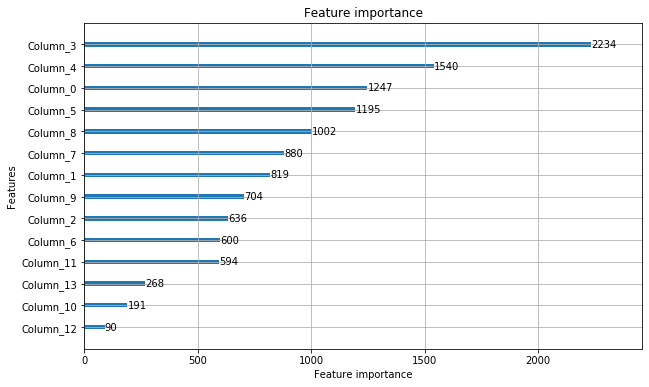

In [33]:
fig, ax = plt.subplots(figsize=(10,6))
lgb.plot_importance(clf, ax)

In [34]:
submit(clf, 'lightbgm_all_features_all_data_2')

# Lightbgm

# Lightbgm train

In [ ]:
params = {'learning_rate': 0.01, 'max_depth': -1, 'boosting': 'gbdt', 
          'objective': 'regression', 'metric': 'mae', 'is_training_metric': True, 
          'num_leaves': 1024, 'feature_fraction': 0.9, 'bagging_fraction': 0.7, 
          'bagging_freq': 5, 'seed':7}

model = lgb.train(params, train, 1000, val, verbose_eval=10, \
                  early_stopping_rounds=100)

In [ ]:
pred = model.predict(x_val)

score(y_val, pred)

# Lightbgm LGBMRegressor

In [ ]:
# lightgbm.LGBMRegressor(boosting_type='gbdt', num_leaves=31, max_depth=- 1, learning_rate=0.1, \
#                              n_estimators=100, subsample_for_bin=200000, objective=None, class_weight=None, \
#                              min_split_gain=0.0, min_child_weight=0.001, min_child_samples=20, subsample=1.0, \
#                              subsample_freq=0, colsample_bytree=1.0, reg_alpha=0.0, reg_lambda=0.0, random_state=None, \
#                              n_jobs=- 1, silent=True, importance_type='split')

In [ ]:
clf = lgb.LGBMRegressor(boosting_type='gbdt', num_leaves=31, max_depth=- 1, learning_rate=0.01, \
                             n_estimators=400, subsample_for_bin=200000, objective=None, class_weight=None, \
                             min_split_gain=0.0, min_child_weight=0.001, min_child_samples=20, subsample=1.0, \
                             subsample_freq=0, colsample_bytree=1.0, reg_alpha=0.0, reg_lambda=0.0, random_state=None, \
                             n_jobs=- 1, silent=True, importance_type='split')

In [ ]:
# fit(X, y, sample_weight=None, init_score=None, eval_set=None, eval_names=None, \
#     eval_sample_weight=None, eval_init_score=None, eval_metric=None, \
#     early_stopping_rounds=None, verbose=True, feature_name='auto', \
#     categorical_feature='auto', callbacks=None, init_model=None)

In [ ]:
clf.fit(x_train, y_train, eval_set=[(x_val, y_val)], \
        eval_metric=maeOverFscore_sklearn, early_stopping_rounds=100, \
        verbose=True, eval_names='maeOverFscore')

# Feature Selection

# KFold

In [ ]:
kfold = KFold(n_splits=4, random_state=7, shuffle=True)

for (train_idx, val_idx) in kfold.split(Y):
    ridge = Ridge(alpha=10.0).fit(X[train_idx, :], Y[train_idx])
    
    score(Y[val_idx], ridge.predict(X[val_idx, :]))

# 시각화

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
lgb.plot_importance(model, ax)

In [ ]:
# lgb_param = {
#     'objective': 'regression',
#     'metrics': maeOverFscore_sklearn,
#     'learning_rate' : 0.01,
#     'eval_metric': maeOverFscore_sklearn,
#     'early_stopping_rounds' : 100,
#     'eval_set': val_data,
#     'verbose': True,
#     'stratified':False,
#     'verbose_eval': 10,
#     'nfold': 5,
#     'num_boost_round': 99999,
# }

# cv_result = lgb.cv(
#     lgb_param,
#     train_data
# )

# lgb_model = lgb.train(
#   lgb_param,
#   train_data,
#   num_boost_round=len(cv_result['l1-mean'])
# )

# Submit

In [ ]:
def submit(clf, name, preprocess=None):
    x_test = reshape(load_data('test'))
    
    if preprocess is not None:
        x_test = preprocess.transform(x_test)
        print("transform")
    
    pred = clf.predict(x_test)

    submission = pd.read_csv(os.path.join(data_path, 'sample_submission.csv'))
    submission.iloc[:, 1:] = pred.reshape(-1, 1600)

    submission.to_csv(os.path.join(submit_path, f'{name}.csv'), index = False)

In [ ]:
submit(lgb_model, 'lightbgm_selectK')

- https://dacon.io/competitions/official/235591/mysubmission/
- D:\인공지능_공모전\github\submit